# Introduzione
Questo progetto mira a condurre un’analisi del dataset Seismic-Bumps, derivato dai dati di monitoraggio sismico raccolti in miniere di carbone attive in Polonia che utilizzano il metodo di estrazione a lunga fronte (longwall mining). L’obiettivo principale è applicare tecniche di data mining per classificare lo stato della massa rocciosa come pericoloso (Hazardous, 1) o non pericoloso (Non-Hazardous, 0), cercando di prevedere l'imminenza di eventi sismici ad alta energia potenzialmente rischiosi per la sicurezza mineraria.

Ogni istanza descrive l'attività sismica registrata durante un turno di lavoro (8 ore) ed è caratterizzata da variabili sia numeriche che categoriche. Queste feature sintetizzano l'energia sismica accumulata, il numero di scosse registrate e le caratteristiche dei tremori precedenti. L'analisi di queste variabili permette di valutare l'aumento dello stress geologico e la deformazione delle rocce, distinguendo tra una normale attività di assestamento e l'accumulo di energia che precede un evento sismico critico

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas.plotting import parallel_coordinates

# --- Per il Caricamento Dati  ---
from sklearn.datasets import fetch_openml
import os
from scipy.io import arff

# --- Per Preprocessing e Valutazione ---
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold

# --- Per i Modelli di Classificazione ---
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from scipy.stats import loguniform, randint # Fondamentale per le distribuzioni
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import math
from sklearn.base import clone
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap

In [3]:
# Costanti globali per garantire riproducibilità e configurabilità
RANDOM_STATE = 42  # Per riproducibilità dei risultati
TEST_SIZE = 0.2    # 20% dei dati per il test set
CV_FOLDS = 5       # 5-fold cross validation

In [4]:
# ==========================================
# 1. CARICAMENTO DATASET (download automatico da UCI)
# ==========================================
filename = 'seismic-bumps.arff'

import urllib.request

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00266/seismic-bumps.arff'

if not os.path.exists(filename):
    print(f"Download del dataset da UCI Repository...")
    try:
        urllib.request.urlretrieve(url, filename)
        print(f"Dataset scaricato: {filename}")
    except Exception as e:
        print(f"Errore download: {e}")
        print(f"Scarica manualmente da: {url}")

if os.path.exists(filename):
    print(f"Caricamento del file '{filename}'...")
    
    # Caricamento diretto da file
    data, meta = arff.loadarff(filename)
    df_raw = pd.DataFrame(data)
    
    # A. Decodifica delle stringhe (da bytes b'...' a stringhe normali)
    # I file ARFF caricano il testo come bytes. Dobbiamo convertirli.
    str_cols = df_raw.select_dtypes([object]).columns
    df_raw[str_cols] = df_raw[str_cols].apply(lambda x: x.str.decode('utf-8'))
    
    # B. Preparazione Target e Feature
    # La colonna target in questo dataset si chiama 'class'
    target_col = 'class'
    
    # Convertiamo il target in interi (0 e 1) per sicurezza
    y = df_raw[target_col].astype(int)
    X = df_raw.drop(target_col, axis=1)

    # C. One-Hot Encoding per le feature categoriche
    # Seismic Bumps contiene lettere (a, b, W, N...). 
    X_encoded = pd.get_dummies(X, drop_first=True, dtype=int)

    # D. Creazione del DataFrame finale 'df'
    # Riuniamo tutto. Questo 'df' è quello che verrà usato dal tuo codice successivo.
    df = pd.concat([X_encoded, y], axis=1)

    print(f"Dataset caricato e processato correttamente.")
    print(f"Dimensioni finali: {df.shape}")
    
    # Impostiamo lo stile grafico
    sns.set_theme(style="darkgrid")

Caricamento del file 'seismic-bumps.arff'...
Dataset caricato e processato correttamente.
Dimensioni finali: (2584, 21)


In [5]:
#Analisi preliminare
print("\n--- Prime 5 righe del DataFrame Combinato ---")
print(df.head())

print("\n--- Informazioni (Tipi di dati e Valori Mancanti) ---")
df.info()


--- Prime 5 righe del DataFrame Combinato ---
   genergy  gpuls  gdenergy  gdpuls  nbumps  nbumps2  nbumps3  nbumps4  \
0  15180.0   48.0     -72.0   -72.0     0.0      0.0      0.0      0.0   
1  14720.0   33.0     -70.0   -79.0     1.0      0.0      1.0      0.0   
2   8050.0   30.0     -81.0   -78.0     0.0      0.0      0.0      0.0   
3  28820.0  171.0     -23.0    40.0     1.0      0.0      1.0      0.0   
4  12640.0   57.0     -63.0   -52.0     0.0      0.0      0.0      0.0   

   nbumps5  nbumps6  ...  nbumps89  energy  maxenergy  seismic_b  \
0      0.0      0.0  ...       0.0     0.0        0.0          0   
1      0.0      0.0  ...       0.0  2000.0     2000.0          0   
2      0.0      0.0  ...       0.0     0.0        0.0          0   
3      0.0      0.0  ...       0.0  3000.0     3000.0          0   
4      0.0      0.0  ...       0.0     0.0        0.0          0   

   seismoacoustic_b  seismoacoustic_c  shift_W  ghazard_b  ghazard_c  class  
0                 0  

Il dataset risulta completo (nessun valore mancante) e interamente numerico, confermando la corretta applicazione del One-Hot Encoding sulle variabili categoriche (es. shift_W, seismic_b).

Tuttavia, le scale dei valori sono molto eterogenee: variabili come genergy raggiungono le migliaia, mentre le altre variabili sono binarie. Per evitare che i modelli siano influenzati solo dalle variabili con valori più alti, la standardizzazione sarà un passaggio fondamentale.

In [6]:
print(f"Shape iniziale: {df.shape}")

# --- Valori mancanti ---
missing = df.isnull().sum()
if missing.sum() > 0:
    print(f"Valori mancanti:\n{missing[missing > 0]}")
    df = df.dropna()
else:
    print("Nessun valore mancante")


# --- Feature a varianza zero/quasi-zero ---
# Rimuove feature con varianza < 0.01 che non portano informazione utile

X_temp = df.drop('class', axis=1)
var_selector = VarianceThreshold(threshold=0.01)
var_selector.fit(X_temp)

low_var_features = X_temp.columns[~var_selector.get_support()].tolist()
if low_var_features:
    print(f"Feature a bassa varianza rimosse: {low_var_features}")
    df = df.drop(columns=low_var_features)
else:
    print("Nessuna feature a bassa varianza")
    
# Aggiorna la lista delle feature dopo la rimozione
feature_column_names = df.drop(columns=['class']).columns.tolist()

Shape iniziale: (2584, 21)
Nessun valore mancante
Feature a bassa varianza rimosse: ['nbumps5', 'nbumps6', 'nbumps7', 'nbumps89']


Dopo aver confermato l'assenza di valori mancanti, è stato applicato un filtro sulla varianza che ha portato alla rimozione di nbumps5, nbumps6, nbumps7 e nbumps89.

La bassa varianza di queste feature indica che eventi sismici di tale intensità (livelli 5-9) sono estremamente rari o assenti nel dataset. Poiché queste colonne contengono quasi esclusivamente lo stesso valore (0), non apportano informazioni utili alla classificazione e la loro rimozione riduce il rumore nel modello.

# INIZIO ANALISI DEL DATASET

Qui vengono mostrati i grafici per un'analisi esplorativa del dataset. Verranno mostrate le distribuzioni delle feature, la correlazione lineare tra esse e la distribuzione delle classi

### Grafico a torta

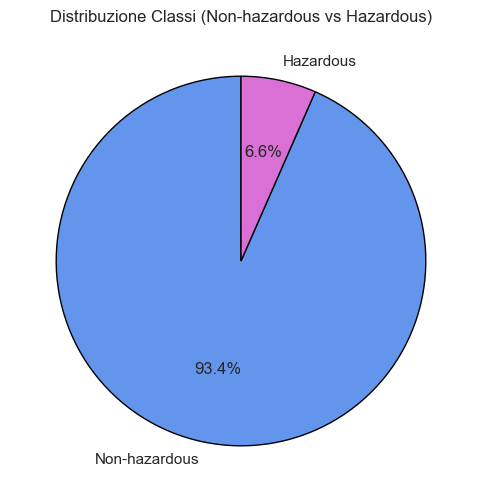

In [7]:
## VISUALIZZAZIONI (Grafico a Torta) ---

#Mappatura delle classi
class_map = {0: 'Non-hazardous', 1: 'Hazardous'}
color_map_dict = {'Non-hazardous': 'cornflowerblue', 'Hazardous': 'orchid'}

# Copia e crea la colonna etichettata
df_plot = df.copy()
df_plot['Event_Label'] = df['class'].map(class_map)
df_plot = df_plot.drop(columns=['class'])

#Grafico a Torta (Distribuzione Classi)
plt.figure(figsize=(6, 6))

# Conta le classi e ordina
counts = df_plot['Event_Label'].value_counts()

# Applica la color map in base all’ordine delle etichette
colors = [color_map_dict[label] for label in counts.index]

# Crea il grafico
counts.plot.pie(
    autopct='%1.1f%%',
    colors=colors,
    wedgeprops={'edgecolor': 'black'},
    startangle=90
)

plt.title('Distribuzione Classi (Non-hazardous vs Hazardous)')
plt.ylabel('')
plt.show()


Il grafico a torta mette in luce una criticità fondamentale del dataset: la distribuzione delle classi è fortemente asimmetrica, con la categoria Non-hazardous che domina il 93.4% delle osservazioni contro appena il 6.6% di eventi Hazardous. Questa sproporzione rende l'accuratezza una metrica potenzialmente ingannevole. Per questo motivo, la valutazione del modello dovrà necessariamente basarsi su metriche più robuste come la Recall e l'F1-Score, e richiederà l'adozione di tecniche specifiche durante l'addestramento, come il bilanciamento dei pesi, per evitare che l'algoritmo ignori la classe minoritaria.

### Grafico coordinate parallele

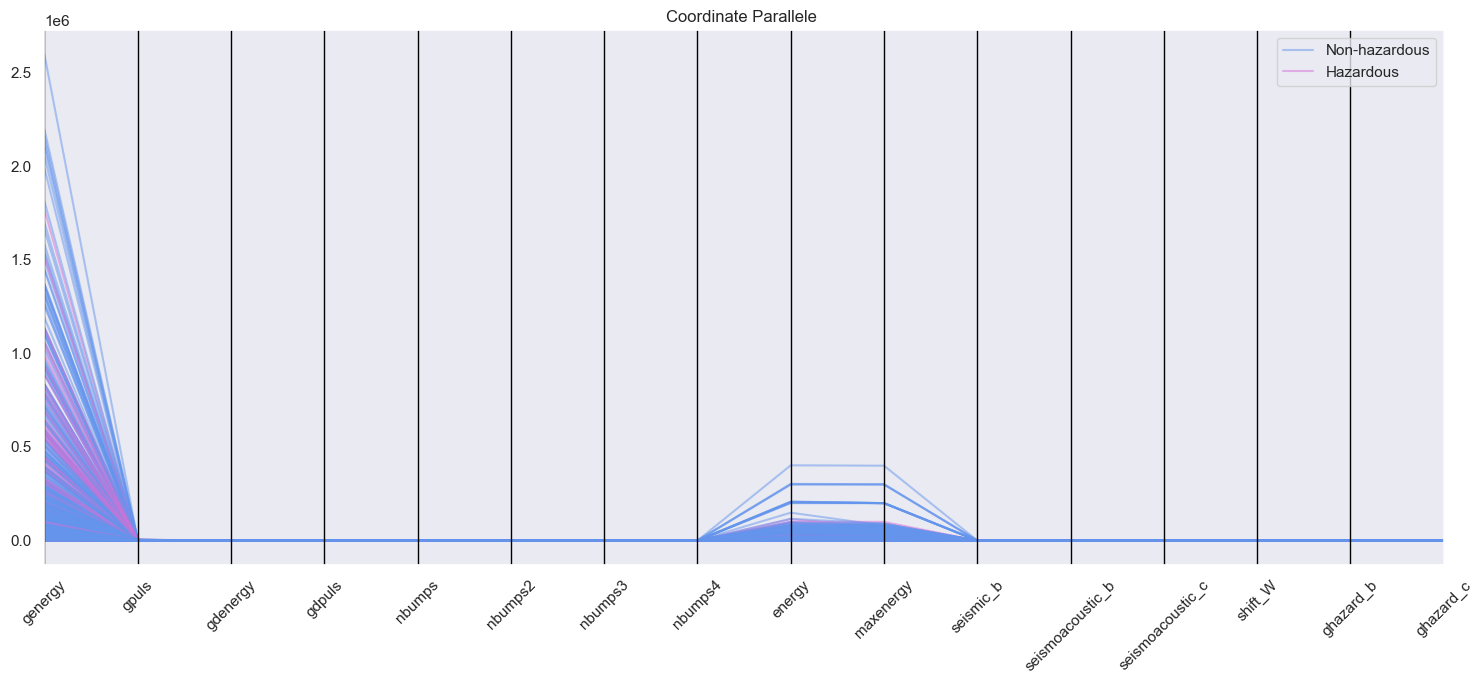

In [8]:
## VISUALIZZAZIONI (Coordinate Parallele - NON Scalati) ---
plt.figure(figsize=(15, 7))

# Grafico delle coordinate parallele
parallel_coordinates(df_plot, 'Event_Label', color=['cornflowerblue', 'orchid'], alpha=0.5)

plt.title('Coordinate Parallele ')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Il grafico a Coordinate Parallele offre una visione d'insieme della distribuzione dei dati, ma mette in luce una criticità tecnica immediata: la drastica differenza di scala tra le variabili. È evidente come la feature genergy domini la visualizzazione con valori che raggiungono i 2.5 milioni, schiacciando visivamente tutte le altre variabili (come i conteggi nbumps o le feature binarie) su una linea piatta prossima allo zero.

Inoltre, la sovrapposizione quasi totale tra le linee blu (Non-hazardous) e quelle rosa (Hazardous) indica che le due classi non sono facilmente separabili guardando le variabili grezze singolarmente. Questa visualizzazione conferma visivamente quanto ipotizzato in precedenza: senza una standardizzazione efficace, qualsiasi algoritmo di Machine Learning verrebbe distorto dalla genergy, ignorando le altre feature che potrebbero contenere i segnali predittivi reali.

### Distribuzione delle feature differenziate per classi

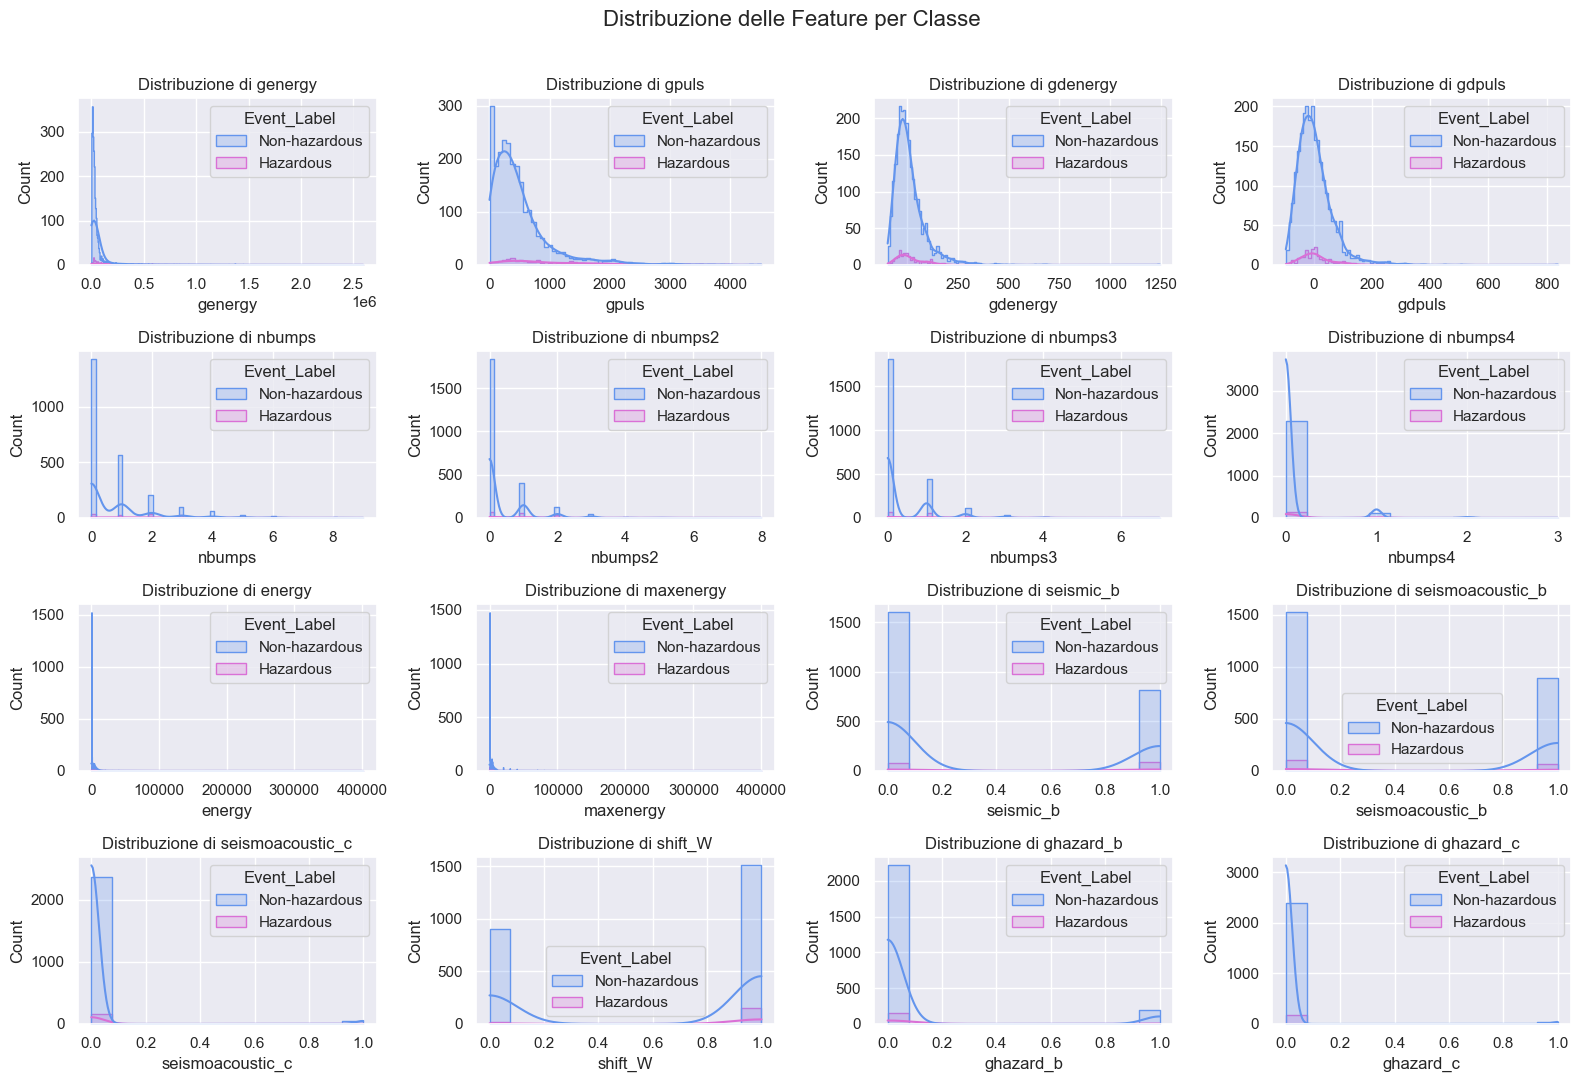

In [9]:
## --- Istogrammi Distribuzioni Feature ---
# Visualizza come le feature discriminano tra classi

plt.figure(figsize=(16, 25))
for i, feature in enumerate(feature_column_names):
    plt.subplot(10, 4, i + 1)
    sns.histplot(
        df_plot,
        x=feature,
        hue='Event_Label',
        kde=True,
        palette=color_map_dict,
        element='step'
    )
    plt.title(f'Distribuzione di {feature}')

plt.tight_layout()
plt.suptitle('Distribuzione delle Feature per Classe', y=1.02, fontsize=16)
plt.show()

L'esame dettagliato delle singole feature rivela una struttura dei dati complessa e tutt'altro che gaussiana. La maggior parte delle variabili continue, in particolare quelle legate all'energia (genergy, energy, maxenergy), mostra una forte asimmetria positiva, con una densità elevata di valori prossimi allo zero e code molto lunghe verso destra. Questo conferma che gli eventi ad altissima energia sono rari e si comportano come outlier rispetto all'attività sismica di fondo.

Dal punto di vista della classificazione, il dato più rilevante è la significativa sovrapposizione tra le distribuzioni delle classi Non-hazardous (blu) e Hazardous (rosa). Non emerge alcuna singola variabile in grado di agire come discriminante netto: i valori associati agli stati pericolosi sono quasi interamente contenuti all'interno del range dei valori sicuri. Questa mancanza di separabilità lineare a livello univariato suggerisce che il modello dovrà necessariamente sfruttare le interazioni complesse e non lineari tra più variabili per identificare correttamente i pattern di rischio.

### Box plot delle feature

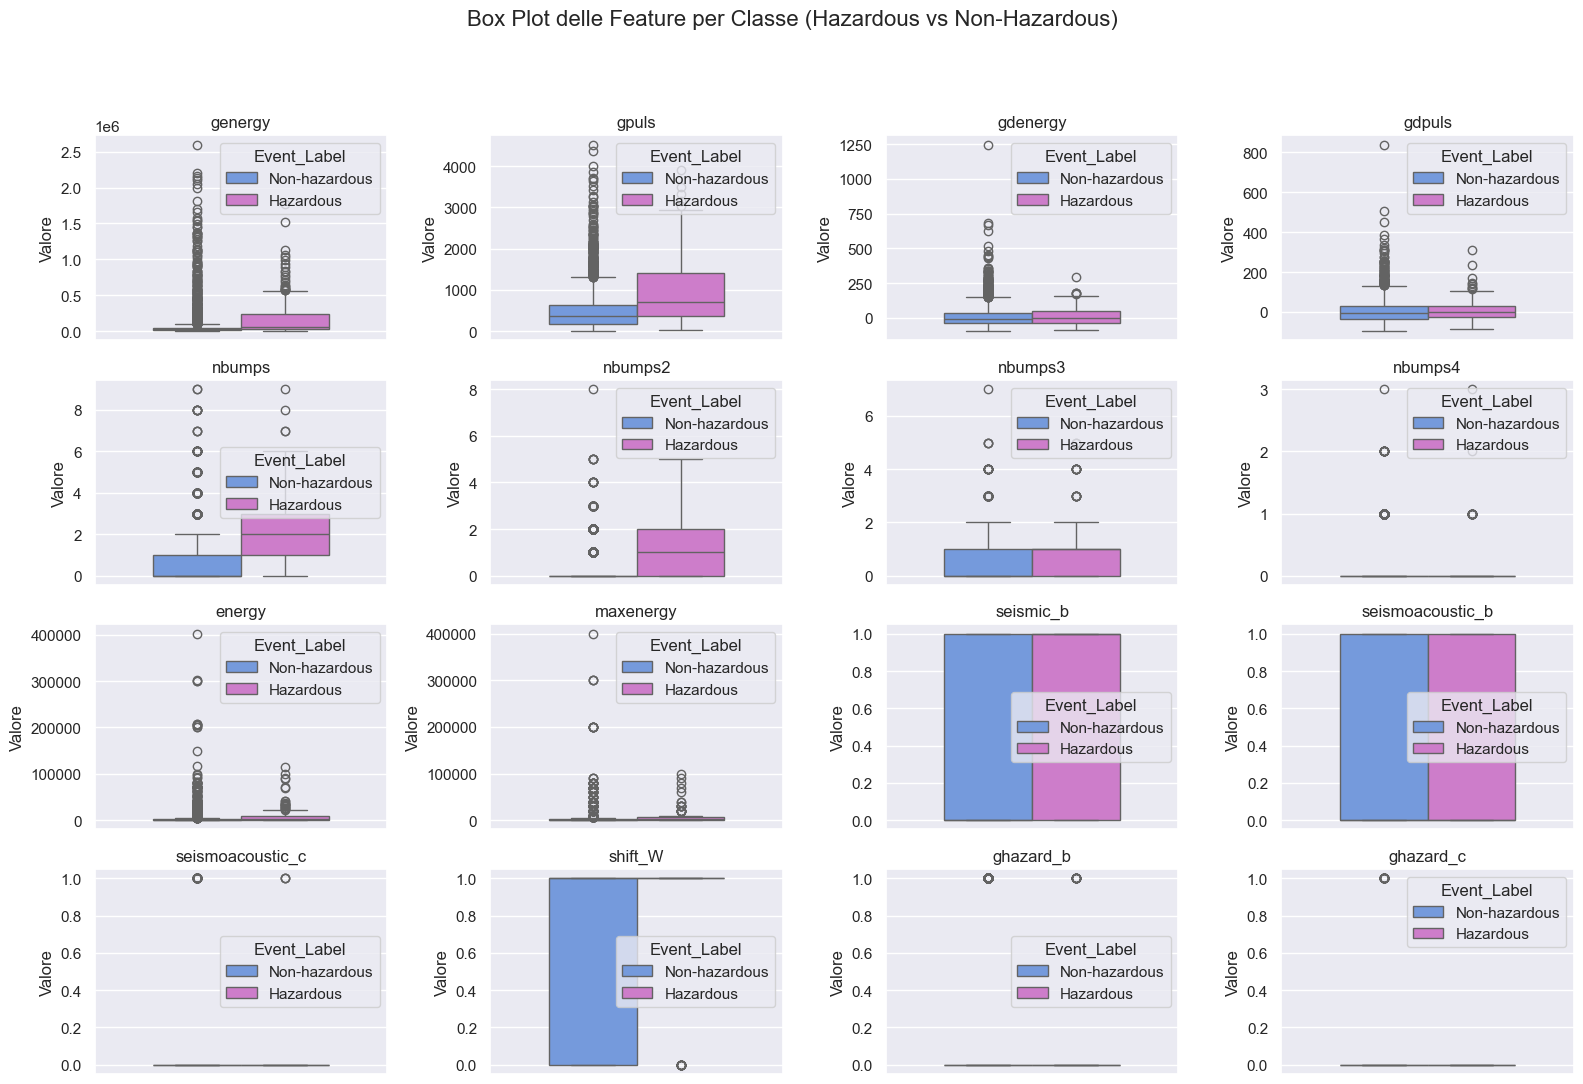

In [10]:
## --- Box Plots per Feature Selezionate ---
# Visualizzazione alternativa per vedere outlier e distribuzione

plt.figure(figsize=(16, 25))
for i, feature in enumerate(feature_column_names):
    plt.subplot(10, 4, i + 1)
    sns.boxplot(
        df_plot,
        hue='Event_Label',
        y=feature,
        palette=color_map_dict,
        width=0.6
    )
    plt.title(feature)
    plt.ylabel('Valore')

plt.suptitle('Box Plot delle Feature per Classe (Hazardous vs Non-Hazardous)', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

L'ispezione tramite Box Plot mette a nudo la natura estrema dei dati sismici, evidenziando una massiccia presenza di outlier (i punti al di sopra dei "baffi") nelle variabili continue come genergy ed energy. Questo conferma una distribuzione fortemente asimmetrica: la stragrande maggioranza degli eventi ha bassa energia, mentre pochi eventi rari raggiungono valori picco elevatissimi.

Confrontando le due classi, emerge comunque un pattern distintivo: per feature come gpuls, nbumps e nbumps2, la distribuzione della classe Hazardous (in viola) è sistematicamente spostata verso valori più alti rispetto alla classe Non-hazardous. Poiché si è scelto di utilizzare lo StandardScaler, è importante notare che la media e la deviazione standard calcolate saranno influenzate da questi picchi estremi; di conseguenza, la maggior parte dei dati verrà compressa in un intervallo ristretto vicino allo zero, mantenendo però visibile la distinzione tra eventi di fondo e picchi sismici.

### Matrice di correlazione lineare tra le feature

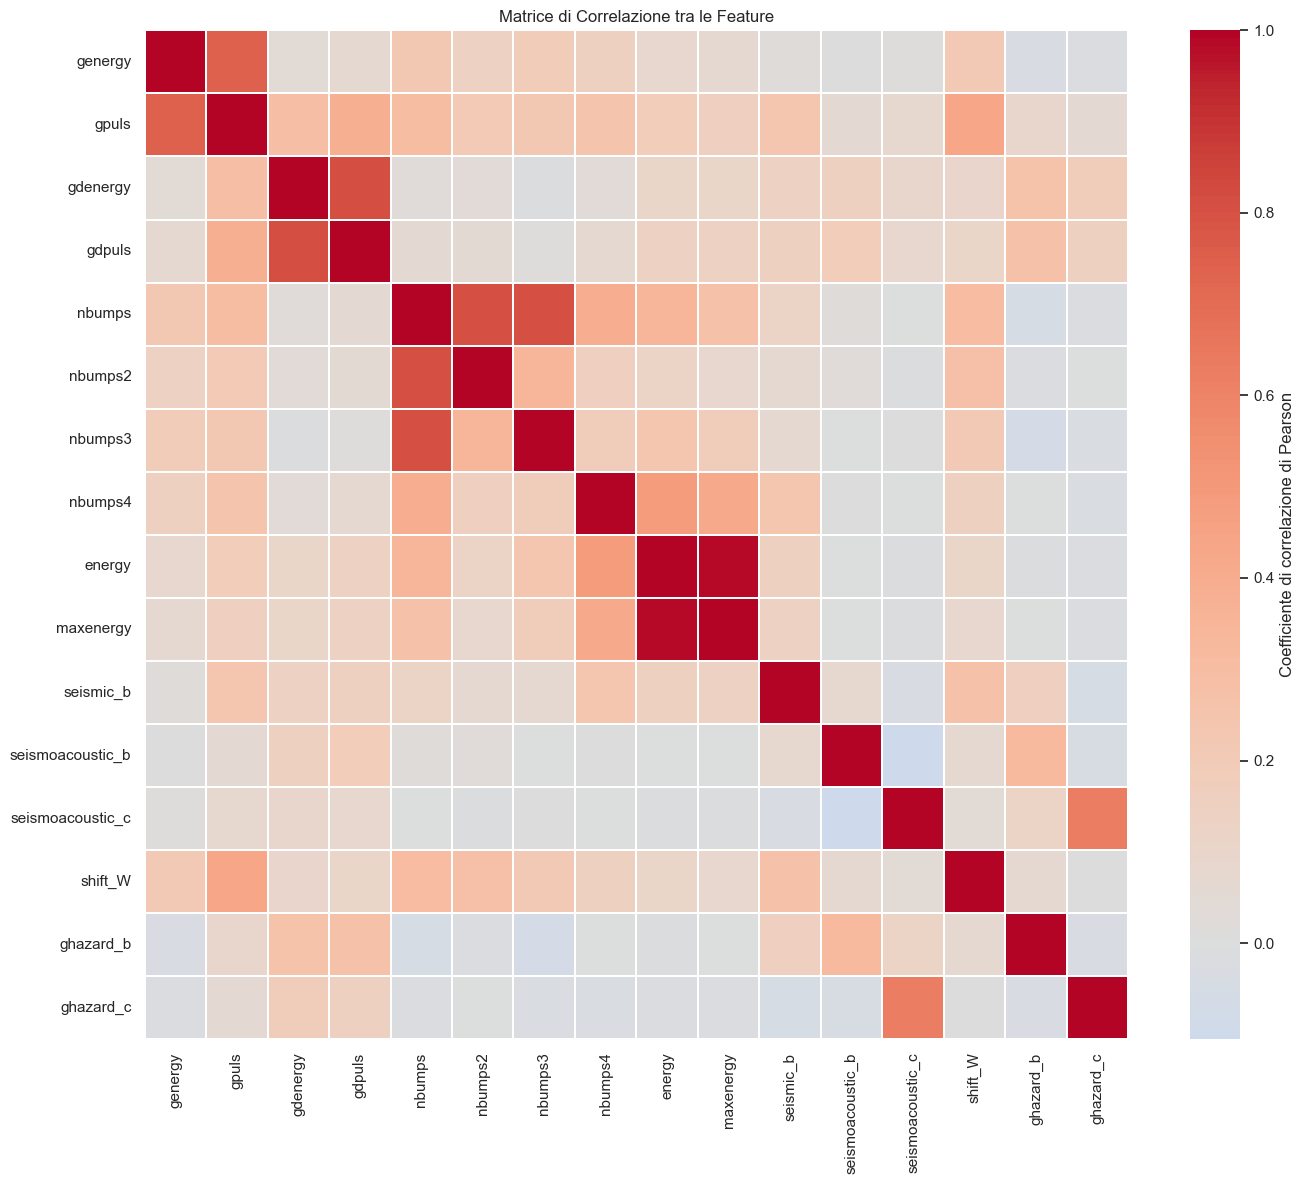

In [11]:
## --- VISUALIZZAZIONI ( Matrice di Correlazione) ---

# Calcolo della matrice di correlazione
corr_matrix = df[feature_column_names].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    annot=False,
    linewidths=0.3,
    cbar_kws={'label': 'Coefficiente di correlazione di Pearson'}
)
plt.title('Matrice di Correlazione tra le Feature')
plt.tight_layout()
plt.show()

L'esame della matrice di correlazione porta alla luce un fenomeno critico per la modellazione: la presenza di una marcata multicollinearità tra diversi gruppi di variabili. Si notano i blocchi di colore rosso scuro, che indicano una correlazione positiva quasi perfetta (prossima a 1.0) tra feature come energy e maxenergy, così come tra le coppie genergy-gpuls e gdenergy-gdpuls.

Questa ridondanza è fisicamente coerente — è logico che all'aumentare dell'energia aumentino anche le pulsazioni registrate — ma dal punto di vista del Machine Learning segnala la presenza di informazioni duplicate. Mantenere tutte queste feature potrebbe non aggiungere valore predittivo e, anzi, rischia di introdurre instabilità in alcuni algoritmi sensibili alle correlazioni lineari. Questo scenario giustifica pienamente l'utilizzo di tecniche di riduzione della dimensionalità, come la PCA (Principal Component Analysis), per condensare queste variabili correlate in un numero minore di componenti indipendenti, mantenendo l'informazione essenziale ma eliminando il rumore ridondante.

# Inizio classificazione: Test Iperparametri di base
Qui inizia la fase di machine learning dove verranno allenati diversi modelli mantenendo gli iperparametri ai loro valori di default. Gli unici iperparametri modificati sono il random_state, per la riproducibilità, e il class_weight/scale_pos_weight, per tenere conto dello sbilanciamento delle classi.

In [12]:
#Separa feature e target
X = df.drop('class', axis=1).values
y = df['class'].values

# Divisione in Train/Test 
# Split Train/Test con stratificazione per mantenere proporzioni
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

print(f"\nDati di Addestramento (X_train): {X_train.shape}")
print(f"Target di Addestramento (y_train): {y_train.shape}")
print(f"Dati di Test (X_test): {X_test.shape}")
print(f"Target di Test (y_test): {y_test.shape}")
print(f"Distribuzione Classi in y_train: {np.bincount(y_train)}")
print(f"Distribuzione Classi in y_test: {np.bincount(y_test)}")


Dati di Addestramento (X_train): (2067, 16)
Target di Addestramento (y_train): (2067,)
Dati di Test (X_test): (517, 16)
Target di Test (y_test): (517,)
Distribuzione Classi in y_train: [1931  136]
Distribuzione Classi in y_test: [483  34]


L'output conferma che lo split dei dati (80% training, 20% test) è avvenuto correttamente, mantenendo inalterata la struttura statistica del dataset. La proporzione critica della classe minoritaria (Hazardous) è stata preservata esattamente al 6.6% sia nel set di addestramento (136 casi) che in quello di test (34 casi) attraverso il parametro stratify.

Questo dettaglio è cruciale per dataset sbilanciati: garantisce che il modello venga addestrato e poi valutato su campioni rappresentativi, evitando il rischio che i rari eventi pericolosi finiscano casualmente tutti in un unico set o viceversa.

In [13]:
#4. Standardizzazione delle variabili
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
def evaluate_model(model, X_test, y_test, average='binary', target_label = 1, verbose=True):
    """
    Valuta un modello calcolando Accuracy, Precision, Recall e F1-score.
    """
    y_pred = model.predict(X_test)

    accuracy  = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred, average=average, pos_label=target_label), 3)
    recall    = round(recall_score(y_test, y_pred, average=average, pos_label=target_label), 3)
    f1        = round(f1_score(y_test, y_pred, average=average, pos_label=target_label), 3)
    
    if verbose:
        print(f"Accuracy:  {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall:    {recall}")
        print(f"F1-score:  {f1}")
    
    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1
    }

In [15]:
models = {
    "Decision Tree": DecisionTreeClassifier(
        random_state=RANDOM_STATE,
        class_weight='balanced' 
    ),

    "KNN": KNeighborsClassifier(
    ),

    "SVM": SVC( 
        random_state=RANDOM_STATE,
        class_weight='balanced'  
    ),

    "MLP": MLPClassifier(
        random_state=RANDOM_STATE,
    ),

    "Random Forest": RandomForestClassifier(
        random_state=RANDOM_STATE,
        class_weight='balanced'  
    ),

    "AdaBoost": AdaBoostClassifier(
        random_state=RANDOM_STATE,  
    ),

    "XGBoost": XGBClassifier(
        random_state=RANDOM_STATE,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()   
    )
}

Viene inizializzato un set eterogeneo di classificatori per confrontare approcci diversi, spaziando da metodi geometrici (SVM, KNN) a modelli basati su alberi (Decision Tree, Random Forest, XGBoost) e reti neurali (MLP).

Un aspetto cruciale in questa configurazione è la gestione esplicita dello sbilanciamento delle classi osservato in precedenza. Per i modelli che lo supportano (SVM, Decision Tree, Random Forest), è stato attivato il parametro class_weight='balanced', che adatta automaticamente i pesi inversamente alla frequenza delle classi. Per XGBoost, è stato calcolato un peso specifico (scale_pos_weight) basato sul rapporto tra le istanze, garantendo che il modello non trascuri la classe minoritaria durante l'addestramento.

In [16]:
AVERAGE_TYPE = 'binary' 
TARGET_LABEL = 1

strat_cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

results = []
conf_matrices = {}

print("Inizio Training con Cross-Validation Stratificata...\n")

# --- CICLO DI TRAINING E VALIDAZIONE ---
for name, model in models.items():
    print(f"Valutazione Modello: {name}")
   
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=strat_cv, scoring='f1')
    
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    print(f">> Stratified CV F1: {cv_mean:.4f} (+/- {cv_std:.4f})")

    model.fit(X_train_scaled, y_train)
    
    metrics = evaluate_model(model, X_test_scaled, y_test, AVERAGE_TYPE, TARGET_LABEL ,True)
    
    metrics["Model"] = name
    results.append(metrics)

    cm = confusion_matrix(y_test, model.predict(X_test_scaled), labels=[0, 1])
    conf_matrices[name] = cm
    
    gen_error = cv_mean - metrics["F1"]
    print(f">> Generalization Error (CV F1 - Test F1): {gen_error:.4f}")
    
    print("   ------------------------------------------------")

print("\nProcesso completato.")

Inizio Training con Cross-Validation Stratificata...

Valutazione Modello: Decision Tree
>> Stratified CV F1: 0.1184 (+/- 0.0599)
Accuracy:  0.907
Precision: 0.25
Recall:    0.206
F1-score:  0.226
>> Generalization Error (CV F1 - Test F1): -0.1076
   ------------------------------------------------
Valutazione Modello: KNN
>> Stratified CV F1: 0.0368 (+/- 0.0302)
Accuracy:  0.932
Precision: 0.429
Recall:    0.088
F1-score:  0.146
>> Generalization Error (CV F1 - Test F1): -0.1092
   ------------------------------------------------
Valutazione Modello: SVM
>> Stratified CV F1: 0.2242 (+/- 0.0303)
Accuracy:  0.785
Precision: 0.14
Recall:    0.441
F1-score:  0.213
>> Generalization Error (CV F1 - Test F1): 0.0112
   ------------------------------------------------
Valutazione Modello: MLP


/opt/miniconda3/envs/imu/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/imu/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/imu/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/imu/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/envs/imu/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/imu/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3

>> Stratified CV F1: 0.0607 (+/- 0.0543)


/opt/miniconda3/envs/imu/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/envs/imu/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/imu/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/imu/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/imu/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/imu/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3

Accuracy:  0.934
Precision: 0.5
Recall:    0.059
F1-score:  0.105
>> Generalization Error (CV F1 - Test F1): -0.0443
   ------------------------------------------------
Valutazione Modello: Random Forest
>> Stratified CV F1: 0.0262 (+/- 0.0321)
Accuracy:  0.936
Precision: 0.667
Recall:    0.059
F1-score:  0.108
>> Generalization Error (CV F1 - Test F1): -0.0818
   ------------------------------------------------
Valutazione Modello: AdaBoost
>> Stratified CV F1: 0.0000 (+/- 0.0000)
Accuracy:  0.934
Precision: 0.0
Recall:    0.0
F1-score:  0.0
>> Generalization Error (CV F1 - Test F1): 0.0000
   ------------------------------------------------
Valutazione Modello: XGBoost


/opt/miniconda3/envs/imu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


>> Stratified CV F1: 0.1514 (+/- 0.0660)
Accuracy:  0.911
Precision: 0.269
Recall:    0.206
F1-score:  0.233
>> Generalization Error (CV F1 - Test F1): -0.0816
   ------------------------------------------------

Processo completato.


I risultati evidenziano un chiaro problema di sbilanciamento delle classi.

Si nota un'Accuratezza molto alta (~93%) che risulta però ingannevole, dato che l'F1-Score è estremamente basso (tra 0.0 e 0.23). Tale discrepanza indica che i modelli, per minimizzare l'errore, tendono a predire quasi esclusivamente la classe maggioritaria, ignorando i casi critici.

In [17]:
df_results = pd.DataFrame(
    results,
    columns=["Model","Accuracy","Precision","Recall","F1"]
).set_index("Model")

# Mostra risultati ordinati per F1 score
df_results.sort_values("F1", ascending=False)

,Accuracy,Precision,Recall,F1
Model,,,,
XGBoost,0.911,0.269,0.206,0.233
Decision Tree,0.907,0.250,0.206,0.226
SVM,0.785,0.140,0.441,0.213
KNN,0.932,0.429,0.088,0.146
Random Forest,0.936,0.667,0.059,0.108
MLP,0.934,0.500,0.059,0.105
AdaBoost,0.934,0.000,0.000,0.000


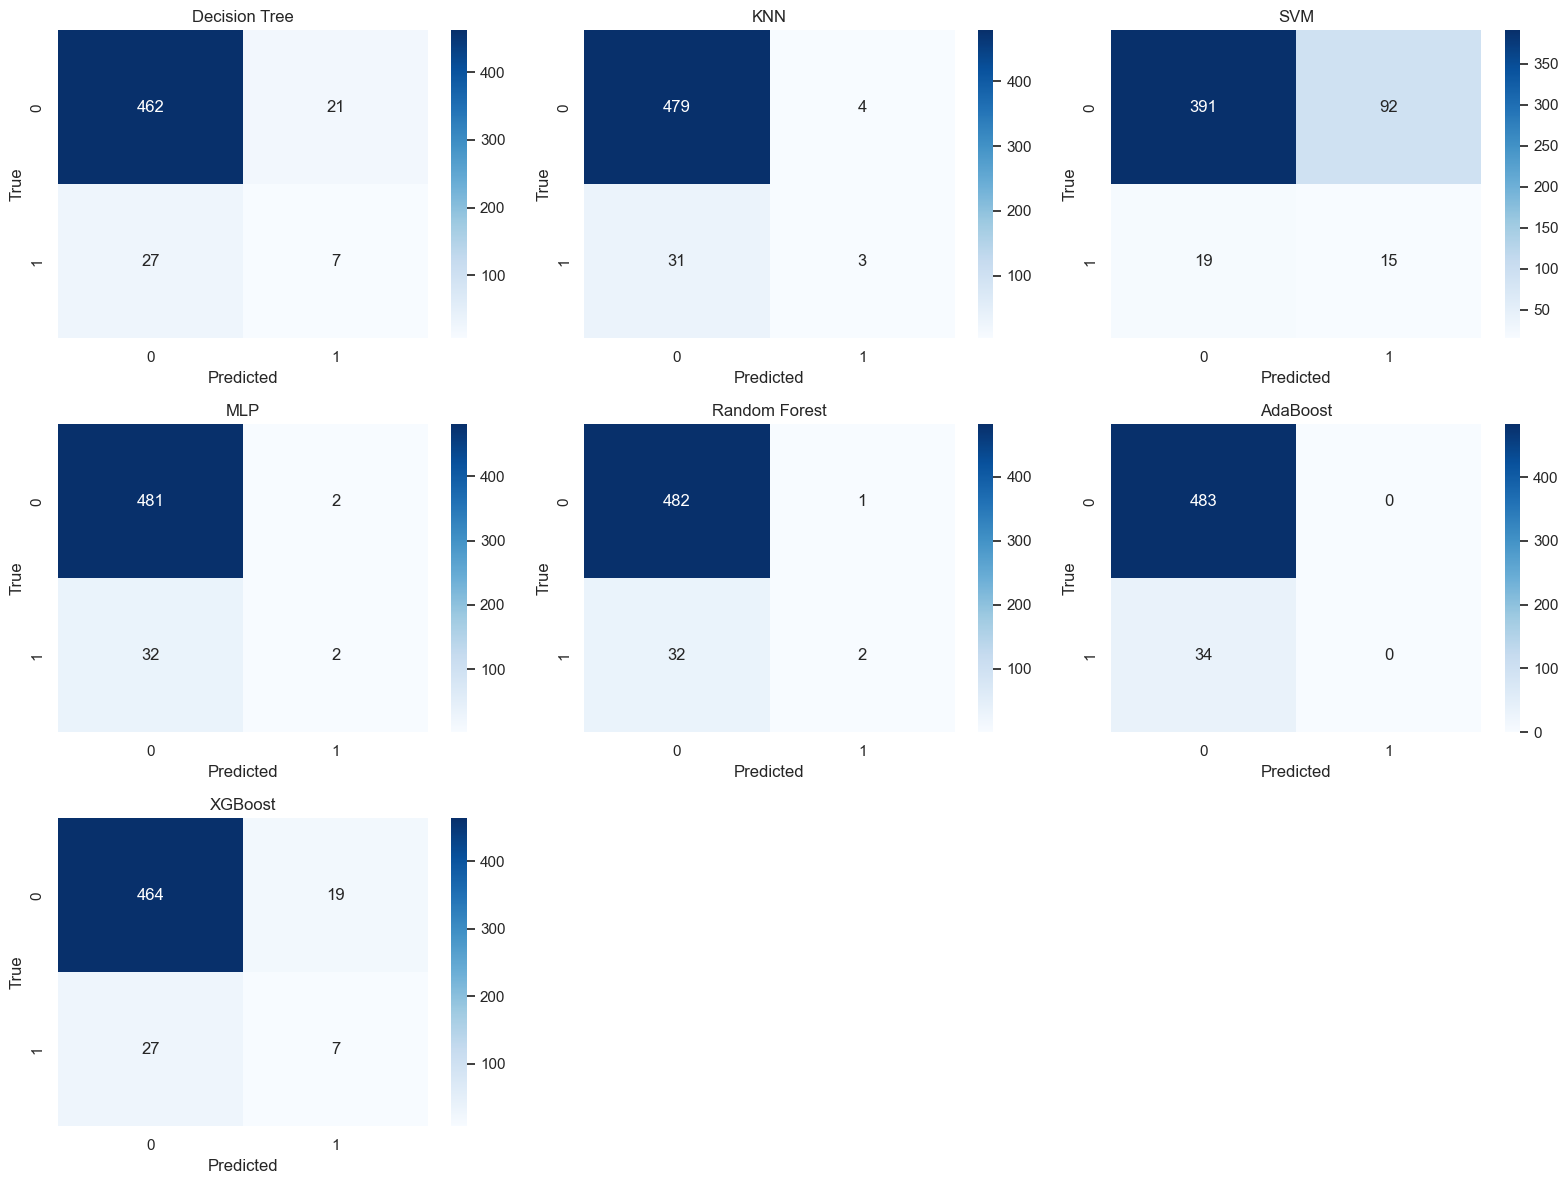

In [18]:
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for i, (name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")

# nascondi subplot vuoti
for j in range(len(conf_matrices), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

La visualizzazione grafica delle matrici di confusione rende immediatamente evidente il comportamento dei classificatori di fronte al forte sbilanciamento del dataset. È da notare come AdaBoost classifica ogni singola istanza come negativa (colonna 0), ottenendo zero veri positivi, mentre MLP ne individua appena 2. In un contesto di rilevamento eventi critici, questi modelli sarebbero inutilizzabili.

L'SVM si conferma l'unico classificatore che riesce a intercettare 15 eventi positivi su 34 (circa il 44%), ma sacrificando pesantemente la precisione con un numero molto elevato di falsi allarmi (92 falsi positivi). Al contrario, algoritmi solitamente robusti come Random Forest e XGBoost si dimostrano qui troppo conservativi, individuando rispettivamente solo 3 e 7 eventi critici e lasciando la stragrande maggioranza dei rischi (27-31 casi) non rilevata.

/opt/miniconda3/envs/imu/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/imu/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/imu/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


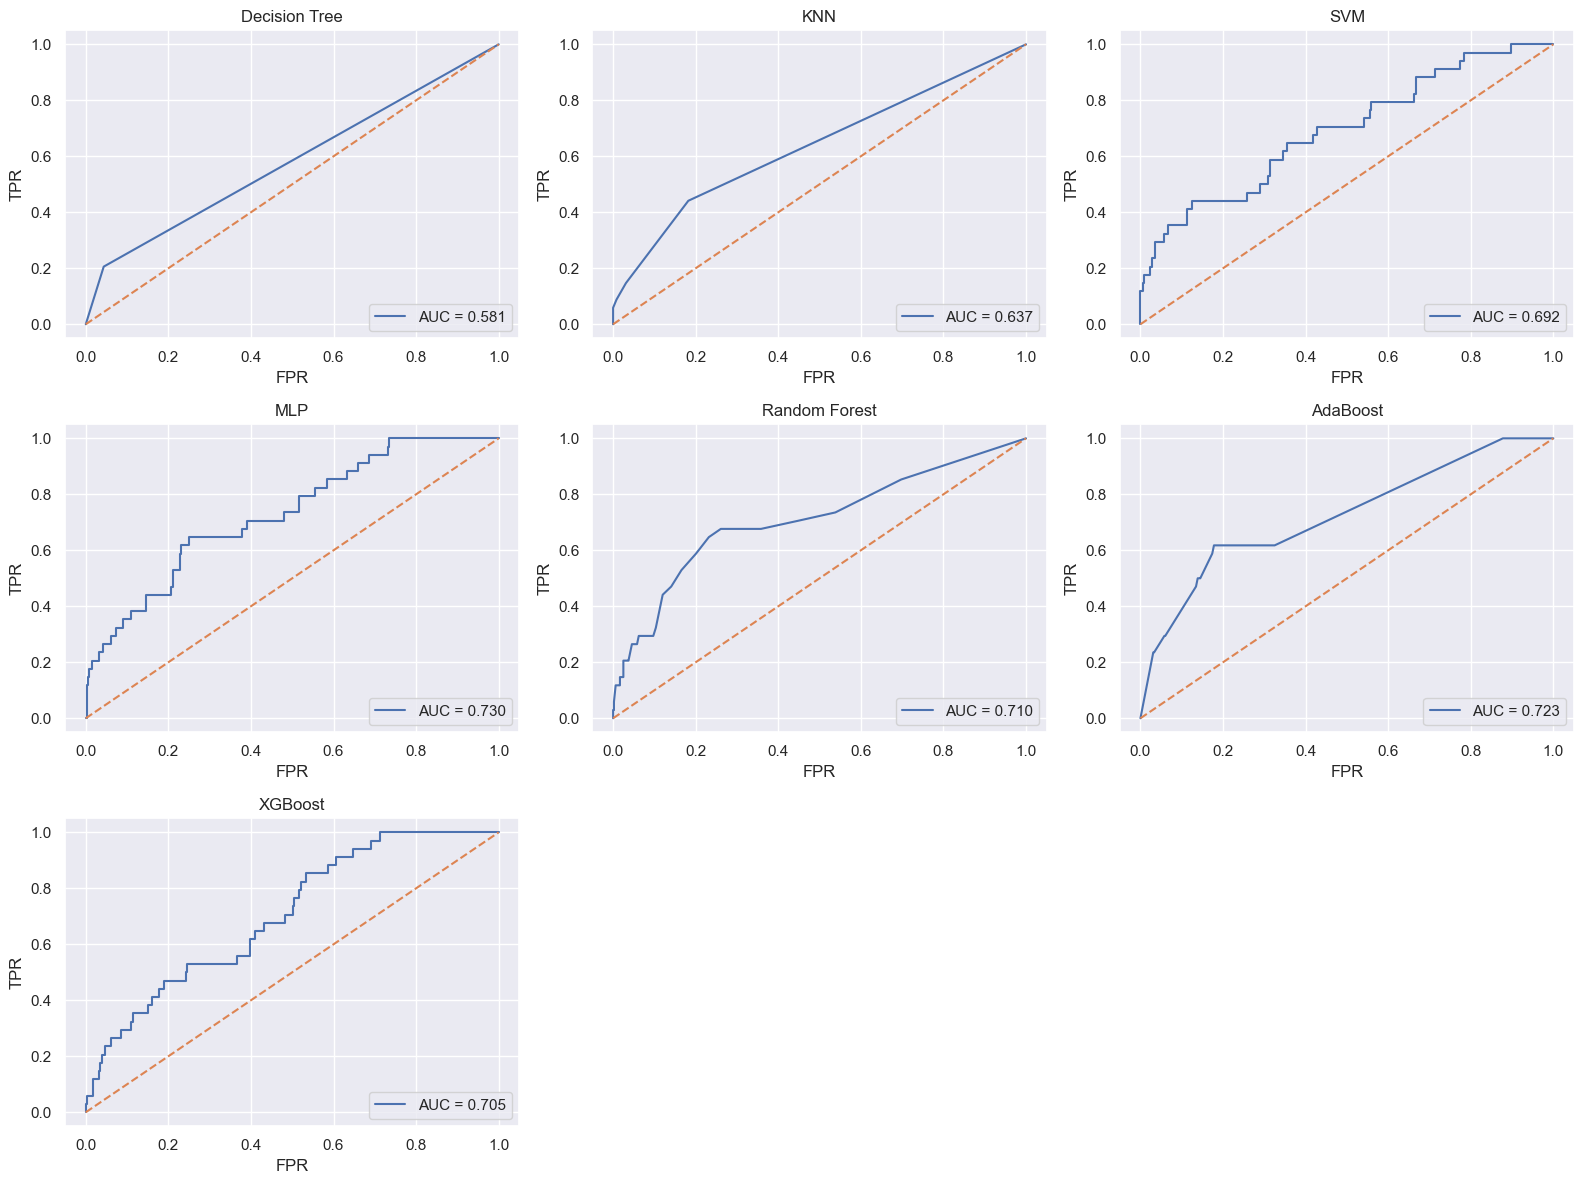

In [19]:
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for i, (name, model) in enumerate(models.items()):
    # prendo lo score continuo
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # per modelli senza predict_proba (es. SVM senza probability=True)
        y_score = model.decision_function(X_test_scaled)
    
    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=TARGET_LABEL)
    auc = roc_auc_score(y_test, y_score)

    ax = axes[i]
    ax.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    ax.plot([0, 1], [0, 1], linestyle="--")  # baseline random
    ax.set_title(name)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.legend(loc="lower right")

# nascondi subplot vuoti se hai meno di 9 modelli
for j in range(len(models), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

Il dato più rilevante è quello dell'MLP, che qui registra l'AUC più alta in assoluto (0.730). Questo risultato è cruciale: sebbene nella matrice di confusione il modello sembrasse inefficace (classificando quasi tutto come negativo), l'elevata area sotto la curva dimostra che la rete neurale ha in realtà appreso correttamente la distinzione probabilistica tra le classi. Il suo fallimento precedente era dovuto esclusivamente a una soglia di decisione mal calibrata per un dataset così sbilanciato, non a una mancanza di apprendimento.

Anche i modelli ensemble confermano questa tesi. AdaBoost (AUC 0.723) e Random Forest (AUC 0.720) mostrano prestazioni solide e molto simili al MLP. Nel caso di AdaBoost, nonostante avesse zero veri positivi nella classificazione iniziale, la sua curva ROC dimostra che il potenziale predittivo è elevato; basterebbe ottimizzare il threshold per trasformarlo in un classificatore migliore.

Al contrario, il Decision Tree (AUC 0.581) si conferma il peggiore modello, con una curva che si discosta appena dalla linea della casualità, mentre l'SVM (AUC 0.693) si posiziona leggermente sotto i metodi ensemble.

<Figure size 1400x700 with 0 Axes>

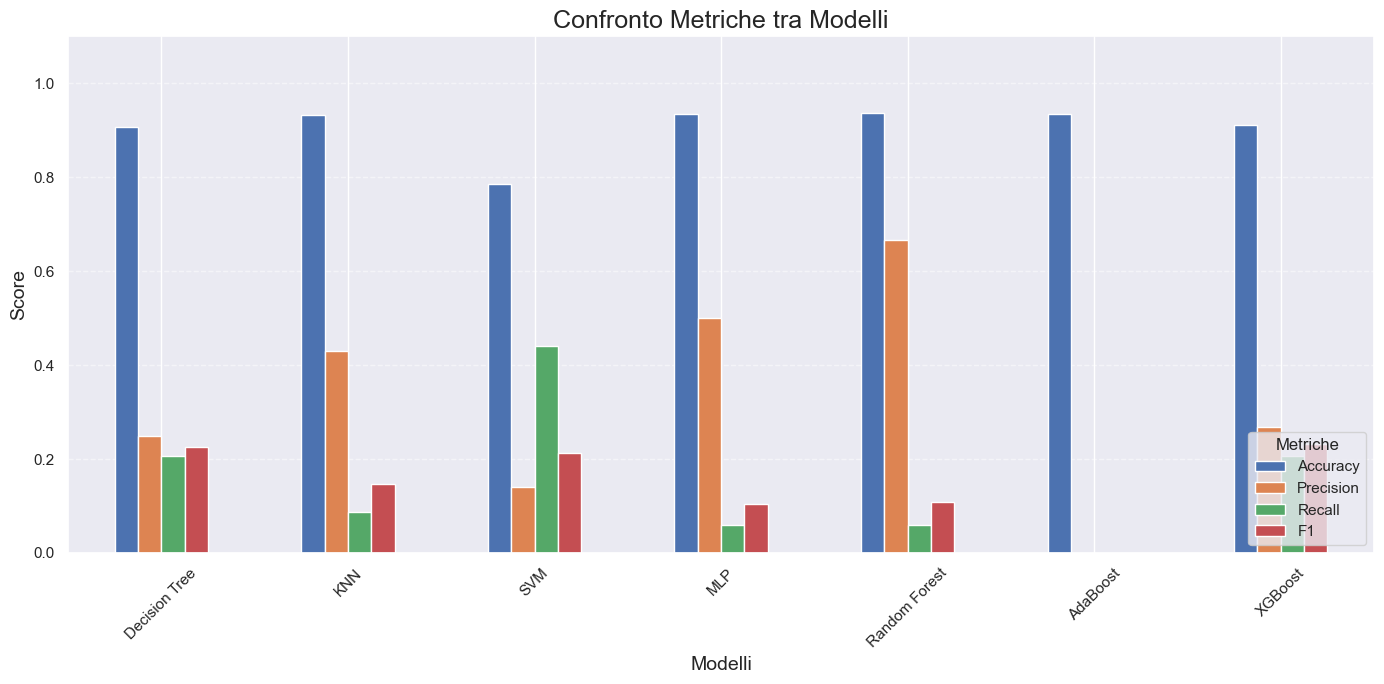

In [20]:
plt.figure(figsize=(14, 7))
df_results.plot(kind='bar', figsize=(14, 7), rot=45)

plt.title("Confronto Metriche tra Modelli", fontsize=18)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Modelli", fontsize=14)
plt.ylim(0, 1.10)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.legend(title='Metriche', fontsize=11, title_fontsize=12, loc='lower right')

plt.tight_layout()
plt.show()

In [21]:
# Identifica il miglior modello basato su F1-score
best_model_name = df_results['F1'].idxmax()
best_f1_score = df_results['F1'].max()

print(f"\nMiglior modello: {best_model_name} con F1-score = {best_f1_score}")

# Estrai il modello migliore
best_model = models[best_model_name]
best_model.fit(X_train_scaled, y_train)


Miglior modello: XGBoost con F1-score = 0.233


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [22]:
def train_eval_2d_models(models, X_train_2d, X_test_2d, y_train, y_test, 
                         feature_names_2d, strat_cv, class_map=None, color_map_dict=None,
                         task_type='binary', pos_label=1, do_plot=True):
    """
        Addestra e valuta modelli su dati ridotti a 2 dimensioni.
        Visualizza anche i decision boundary per analisi visiva.
        
        Parameters:
        -----------
        models : dict - dizionario nome:modello
        X_train_2d, X_test_2d : dati 2D
        y_train, y_test : labels
        feature_names_2d : nomi delle 2 feature/componenti
        strat_cv :  stratified cross-validation
        do_plot : se True, visualizza il plot deidecision boundaries
    """
    results = {}
    
    # Setup per visualizzazione decision boundary
    if do_plot:
        n_models = len(models)
        n_cols = min(3, n_models)
        n_rows = math.ceil(n_models / n_cols)
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))
        if n_models == 1:
            axes = [axes]
        else:
            axes = axes.ravel() if n_rows > 1 or n_cols > 1 else [axes]
    
    for idx, (name, model) in enumerate(models.items()):
        # Clone del modello
        model_clone = clone(model)
        
        # Scelta dello scoring per CV 
        if task_type == 'binary':
            scoring = 'f1' if pos_label == 1 else make_scorer(f1_score, pos_label=pos_label)
        else:
            scoring = 'f1_weighted'
            
        # Cross-validation
        cv_scores = cross_val_score(model_clone, X_train_2d, y_train, cv=strat_cv, scoring=scoring)
        
        # Training
        model_clone.fit(X_train_2d, y_train)
        
        # Predizione
        y_pred = model_clone.predict(X_test_2d)
        
        # Calcolo metriche 
        if task_type == 'binary':
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, pos_label=pos_label)
            rec = recall_score(y_test, y_pred, pos_label=pos_label)
            f1 = f1_score(y_test, y_pred, pos_label=pos_label)
        else:
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, average='weighted')
            rec = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Salva risultati
        results[name] = {
            'model': model_clone,
            'cv_scores': cv_scores,
            'metrics': {
                'Accuracy': round(acc, 3),
                'Precision': round(prec, 3),
                'Recall': round(rec, 3),
                'F1': round(f1, 3)
            },
            'predictions': y_pred
        }
        
        # Plot decision boundary
        if do_plot:
            ax = axes[idx]

            mesh_cmap = ListedColormap([
                color_map_dict[class_map[0]],
                color_map_dict[class_map[1]]
            ])
            
            # Crea mesh
            h = 0.02 # Step size nel mesh
            x_min, x_max = X_train_2d[:, 0].min() - 0.5, X_train_2d[:, 0].max() + 0.5
            y_min, y_max = X_train_2d[:, 1].min() - 0.5, X_train_2d[:, 1].max() + 0.5
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
            
            # Predizioni sul mesh
            Z = model_clone.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            
            # Plot contorno
            ax.contourf(xx, yy, Z, alpha=0.8, cmap=mesh_cmap)
            
            # Plot punti training
            train_colors = [color_map_dict[class_map[label]] for label in y_train]

            ax.scatter(
                X_train_2d[:, 0], X_train_2d[:, 1],
                c=train_colors,
                edgecolor='k', s=50, alpha=0.7
            )
            
            legend_elements = [
                Line2D(
                    [0], [0],
                    marker='o', color='w',
                    label=cls,
                    markerfacecolor=col,
                    markersize=8
                )
                for cls, col in color_map_dict.items()
            ]

            ax.legend(handles=legend_elements)
            
            ax.set_xlabel(feature_names_2d[0])
            ax.set_ylabel(feature_names_2d[1])
            ax.set_title(f'{name}\nTest F1={f1:.3f}')
            
            
    if do_plot:
        # Nascondi subplot vuoti
        for j in range(len(models), len(axes)):
            axes[j].set_visible(False)
        
        plt.tight_layout()
        plt.show()
    
    # Stampa risultati per il miglior modello
    best_model_name = max(results.keys(), key=lambda x: results[x]['metrics']['F1'])
    cv_scores = results[best_model_name]['cv_scores']
    print(f"\n=== Modello: {best_model_name} ===")
    print(f"   >> Stratified CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"   >> Metriche test: {results[best_model_name]['metrics']}")
    
    return results

# Inizio fase di riduzione dimensionalità
Per ridurre la complessità computazionale, verranno applicate tecniche di Feature Selection ed Extraction. Una volta identificate le due feature (o componenti) più significative per ciascun metodo, valuteremo la loro efficacia addestrando nuovamente il modello che ha mostrato le migliori performance sul dataset originale.

### 1. PCA - Principal Component Analysis

In [23]:
print("=== Analisi PCA ===")

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"\nVarianza per componente:")
for i, var in enumerate(pca.explained_variance_ratio_, 1):
    print(f"  PC{i}: {var:.3f} ({var*100:.1f}%)")

pca_feature_names = [f'PC{i+1}' for i in range(2)]

total_var = pca.explained_variance_ratio_.sum()
print(f"\nVarianza totale spiegata: {total_var:.3f} ({total_var*100:.1f}%)")
print(f"Informazione persa: {1-total_var:.3f} ({(1-total_var)*100:.1f}%)")

=== Analisi PCA ===

Varianza per componente:
  PC1: 0.227 (22.7%)
  PC2: 0.144 (14.4%)

Varianza totale spiegata: 0.371 (37.1%)
Informazione persa: 0.629 (62.9%)


/opt/miniconda3/envs/imu/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/opt/miniconda3/envs/imu/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/opt/miniconda3/envs/imu/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/opt/miniconda3/envs/imu/lib/python3.12/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/opt/miniconda3/envs/imu/lib/python3.12/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/opt/miniconda3/envs/imu/lib/python3.12/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.componen

I risultati dipingono un quadro di notevole complessità. Con le sole due componenti principali, riusciamo a catturare appena il 37.1% della varianza totale, perdendo inevitabilmente oltre il 60% dell'informazione originale.

Questo dato indica che il segnale utile non è concentrato in poche variabili dominanti, ma è distribuito su molte dimensioni. Di conseguenza, è prevedibile che la visualizzazione 2D risulterà confusa, con una forte sovrapposizione tra le classi, poiché gran parte dei dettagli necessari a distinguere gli eventi pericolosi è rimasta nelle dimensioni sacrificate dalla compressione.

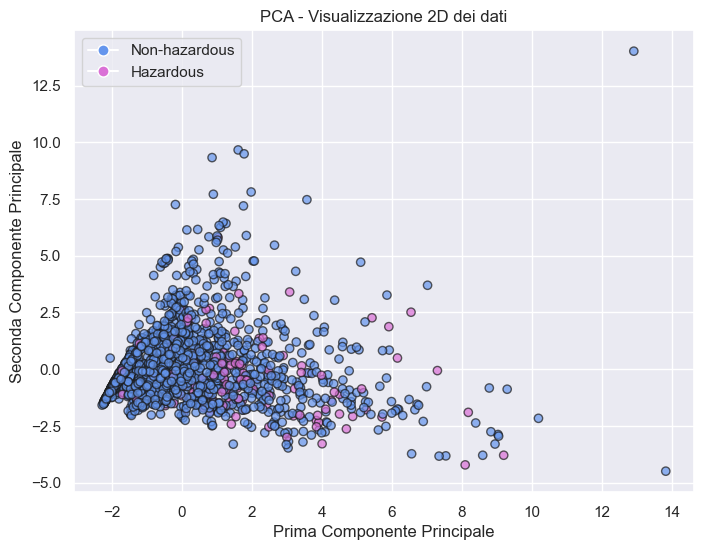

In [24]:
# Visualizza PCA

class_map = {0: 'Non-hazardous', 1: 'Hazardous'}
colors = [color_map_dict[class_map[label]] for label in y_train]

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=colors,
                    edgecolor='k', alpha=0.7)
plt.xlabel('Prima Componente Principale')
plt.ylabel('Seconda Componente Principale')
plt.title('PCA - Visualizzazione 2D dei dati')

legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label=cls, markerfacecolor=col, markersize=8)
    for cls, col in color_map_dict.items()
]

plt.legend(handles=legend_elements)

plt.show()

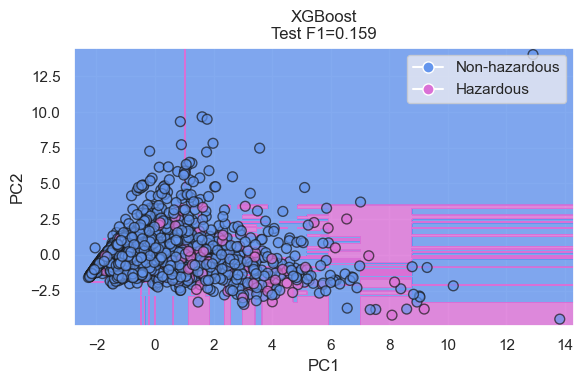


=== Modello: XGBoost ===
   >> Stratified CV F1: 0.1454 (+/- 0.0940)
   >> Metriche test: {'Accuracy': 0.857, 'Precision': 0.13, 'Recall': 0.206, 'F1': 0.159}


In [25]:
# Valuta solo il miglior modello con PCA
models_pca = {best_model_name: models[best_model_name]}

results_pca = train_eval_2d_models(
    models=models_pca,
    X_train_2d=X_train_pca,
    X_test_2d=X_test_pca,
    y_train=y_train,
    y_test=y_test,
    feature_names_2d=pca_feature_names,
    strat_cv=strat_cv,
    task_type='binary',
    class_map=class_map,
    color_map_dict=color_map_dict,
    pos_label=TARGET_LABEL,
    do_plot=True
)

Il grafico offre la conferma visiva di quanto anticipato dall'analisi della varianza: con un F1-Score di appena 0.159, il modello non riesce a gestire la complessità dei dati compressi.

La sovrapposizione tra le classi è quasi totale. Di conseguenza, l'XGBoost fatica a trovare una regola generale per classificare gli eventi. È la prova che le due dimensioni principali non contengono abbastanza informazioni per distinguere un evento sismico pericoloso dal fondo.

### 2. Feature Importance

In [26]:
importances = best_model.feature_importances_

# Ordina le feature per importanza
indices = np.argsort(importances)[::-1]
top_2_features = indices[:2]


# Seleziona top 2 features
X_train_fi = X_train_scaled[:, top_2_features]
X_test_fi = X_test_scaled[:, top_2_features]
feature_names_fi = [feature_column_names[i] for i in top_2_features]

print("Feature scelte:", feature_names_fi)

Feature scelte: ['nbumps', 'shift_W']


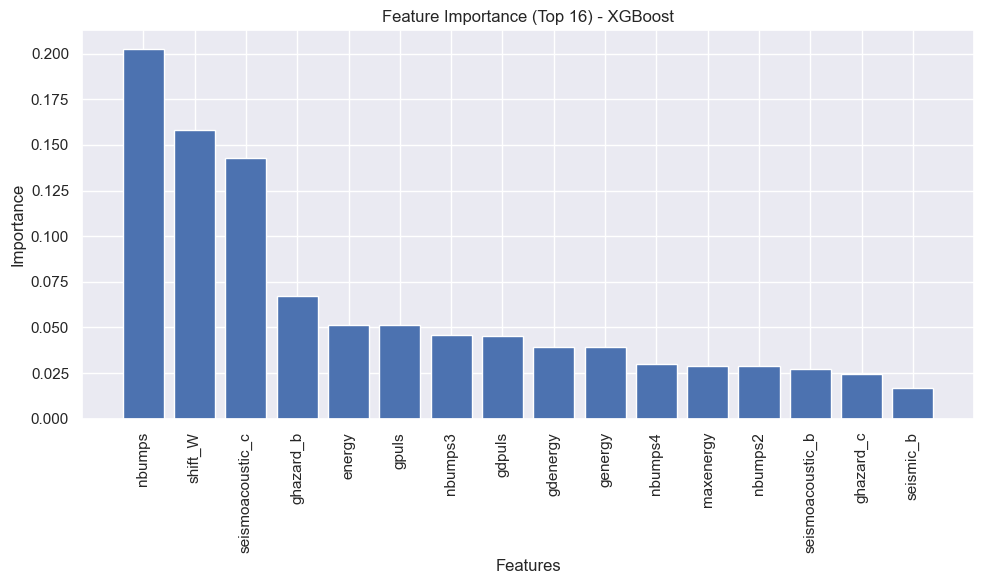

In [27]:
top_n = min(34, len(importances))
plt.figure(figsize=(10, 6))
plt.bar(range(top_n), importances[indices[:top_n]])
plt.xticks(range(top_n), [feature_column_names[i] for i in indices[:top_n]], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title(f'Feature Importance (Top {top_n}) - {best_model_name}')
plt.tight_layout()
plt.show()

L'XGBoost si affida quasi tutto a tre variabili principali per valutare il rischio.

Al primo posto domina nbumps (il numero di scosse), che si conferma l'indicatore più forte in assoluto. Seguono shift_W e seismoacoustic_c.

Dopo le prime tre c'è un crollo dell'importanza: variabili come l'energia (energy) o i pulse (gpuls), che potevano sembrare importanti, hanno un peso molto basso (sotto 0.07), agendo più come dettagli di contorno che come fattori decisivi.

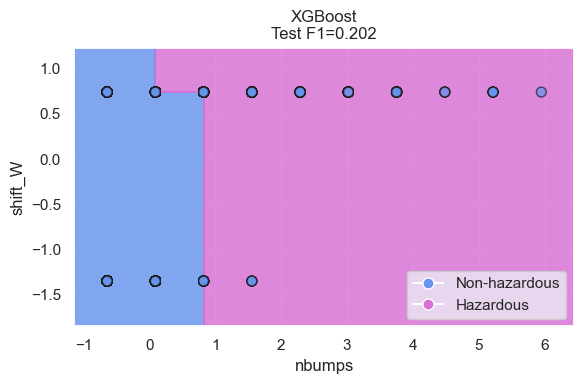


=== Modello: XGBoost ===
   >> Stratified CV F1: 0.2297 (+/- 0.0144)
   >> Metriche test: {'Accuracy': 0.679, 'Precision': 0.121, 'Recall': 0.618, 'F1': 0.202}


In [28]:
results_fi = train_eval_2d_models(
    models=models_pca,
    X_train_2d=X_train_fi,
    X_test_2d=X_test_fi,
    y_train=y_train,
    y_test=y_test,
    feature_names_2d=feature_names_fi,
    strat_cv=strat_cv,
    task_type='binary',
    class_map=class_map,
    color_map_dict=color_map_dict,
    pos_label=TARGET_LABEL,
    do_plot=True
)

Utilizzando le due variabili migliori (nbumps e shift_W), l'F1-Score sale a 0.202. È un risultato ancora modesto, ma comunque migliore rispetto alla PCA (0.159).

Dall'immagine si nota che il modello ignora quasi del tutto la variabile sull'asse verticale (shift_W) e basa la decisione esclusivamente sul numero di scosse (nbumps). Si vede infatti un confine netto e verticale: se le scosse sono poche (0 o 1), il modello prevede sicurezza (zona blu); appena le scosse salgono a 2 o più, scatta l'allarme (zona rosa). È una regola elementare (più scosse = pericolo) che cattura una parte del problema, ma è troppo grossolana per garantire un'alta affidabilità.

### 3. RFE - Recursive Feature Elimination

In [29]:
# RFE con il miglior modello
rfe = RFE(clone(best_model), n_features_to_select=2)
rfe.fit(X_train_scaled, y_train)

# Feature selezionate
rfe_selected_features = np.where(rfe.support_)[0]
print(f"\nFeatures selezionate da RFE: {[feature_column_names[i] for i in rfe_selected_features]}")

# Trasforma i dati
X_train_rfe = rfe.transform(X_train_scaled)
X_test_rfe = rfe.transform(X_test_scaled)
feature_names_rfe = [feature_column_names[i] for i in rfe_selected_features]


Features selezionate da RFE: ['nbumps', 'shift_W']


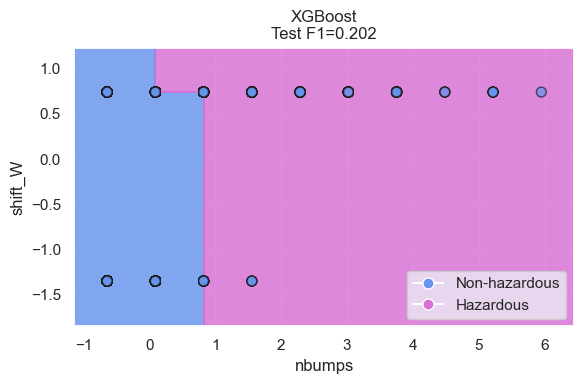


=== Modello: XGBoost ===
   >> Stratified CV F1: 0.2297 (+/- 0.0144)
   >> Metriche test: {'Accuracy': 0.679, 'Precision': 0.121, 'Recall': 0.618, 'F1': 0.202}


In [30]:
results_rfe = train_eval_2d_models(
    models=models_pca,
    X_train_2d=X_train_rfe,
    X_test_2d=X_test_rfe,
    y_train=y_train,
    y_test=y_test,
    feature_names_2d=feature_names_rfe,
    strat_cv=strat_cv,
    task_type='binary',
    class_map=class_map,
    color_map_dict=color_map_dict,
    pos_label=TARGET_LABEL,
    do_plot=True
)

Anche l'utilizzo della RFE (Recursive Feature Elimination) porta alla selezione delle medesime feature (nbumps e shift_W), replicando esattamente il risultato precedente.

## 4. Mutual Information

In [31]:
# Calcola mutual information
mi_scores = mutual_info_classif(X_train_scaled, y_train)

# Seleziona top 2 features
mi_indices = np.argsort(mi_scores)[::-1][:2]

print(f"\nTop 2 features per MI: {[feature_column_names[i] for i in mi_indices]}")

# Seleziona le features
X_train_mi = X_train_scaled[:, mi_indices]
X_test_mi = X_test_scaled[:, mi_indices]
feature_names_mi = [feature_column_names[i] for i in mi_indices]


Top 2 features per MI: ['energy', 'nbumps2']


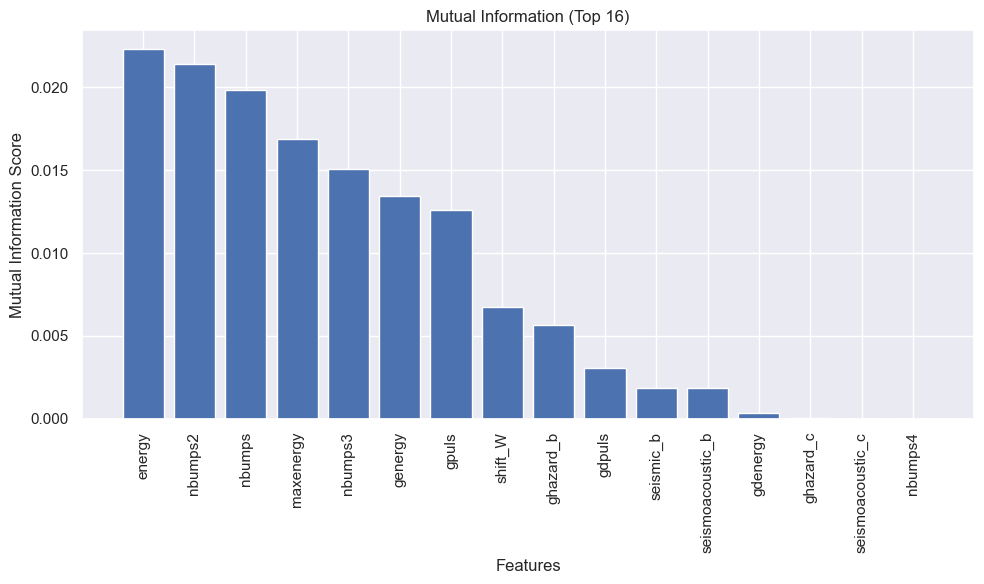

In [32]:
# Visualizza mutual information 
top_n = min(16, len(mi_scores))
plt.figure(figsize=(10, 6))
mi_sorted_indices = np.argsort(mi_scores)[::-1][:top_n]
plt.bar(range(top_n), mi_scores[mi_sorted_indices])
plt.xticks(range(top_n), [feature_column_names[i] for i in mi_sorted_indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.title(f'Mutual Information (Top {top_n})')
plt.tight_layout()
plt.show()

In questo grafico vediamo un cambiamento interessante rispetto all'analisi precedente. La Mutual Information valuta come più importante l'energia totale (energy), che supera il numero di scosse (nbumps).

È comunque chiaro che queste due grandezze rimangono le più importanti del dataset, dato che anche le varianti come nbumps2, nbumps3 e maxenergy occupano tutte le posizioni di testa. Un altro aspetto fondamentale è che l'informazione utile si esaurisce in fretta: solo le prime 7-8 variabili hanno un peso rilevante, mentre tutte le altre a destra sono praticamente a zero, confermando che gran parte delle feature registrate non aiuta a distinguere gli eventi pericolosi.

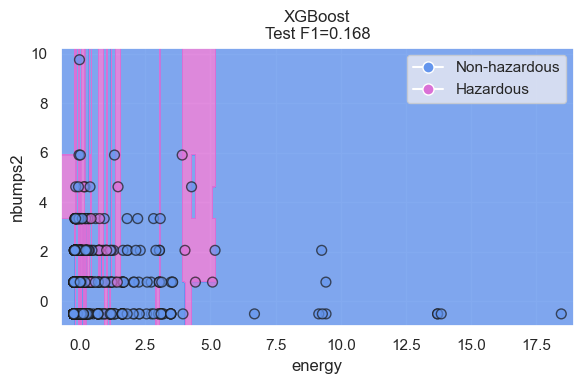


=== Modello: XGBoost ===
   >> Stratified CV F1: 0.1424 (+/- 0.0329)
   >> Metriche test: {'Accuracy': 0.809, 'Precision': 0.118, 'Recall': 0.294, 'F1': 0.168}


In [33]:
results_mi = train_eval_2d_models(
    models=models_pca,
    X_train_2d=X_train_mi,
    X_test_2d=X_test_mi,
    y_train=y_train,
    y_test=y_test,
    feature_names_2d=feature_names_mi,
    strat_cv=strat_cv,
    task_type='binary',
    class_map=class_map,
    color_map_dict=color_map_dict,
    pos_label=TARGET_LABEL,
    do_plot=True
)

Usando la coppia suggerita dalla Mutual Information (energy e nbumps), il risultato peggiora rispetto a prima: l'F1-Score scende a 0.168.

Nel grafico si possono notare tante bande verticali strette e disordinate. Sembra che il modello stia cercando di ritagliare specifici intervalli di energia, ma il risultato è una mappa frammentata e confusa che non riesce a separare i dati con sicurezza. Evidentemente, sostituire la variabile shift_W con l'energia ha reso il compito più difficile per il classificatore.

In [34]:
df_compare = pd.DataFrame({
    "Original": df_results["F1"][best_model_name],
    "PCA": results_pca[best_model_name]["metrics"]["F1"],
    "Feature Importance": results_fi[best_model_name]["metrics"]["F1"],
    "RFE": results_rfe[best_model_name]["metrics"]["F1"],
    "Mutual Information": results_mi[best_model_name]["metrics"]["F1"],
}, index=["F1"])

print(f"\nConfronto metodi di Feature Selection per {best_model_name}:")
df_compare


Confronto metodi di Feature Selection per XGBoost:


,Original,PCA,Feature Importance,RFE,Mutual Information
F1,0.233,0.159,0.202,0.202,0.168


<Figure size 1000x600 with 0 Axes>

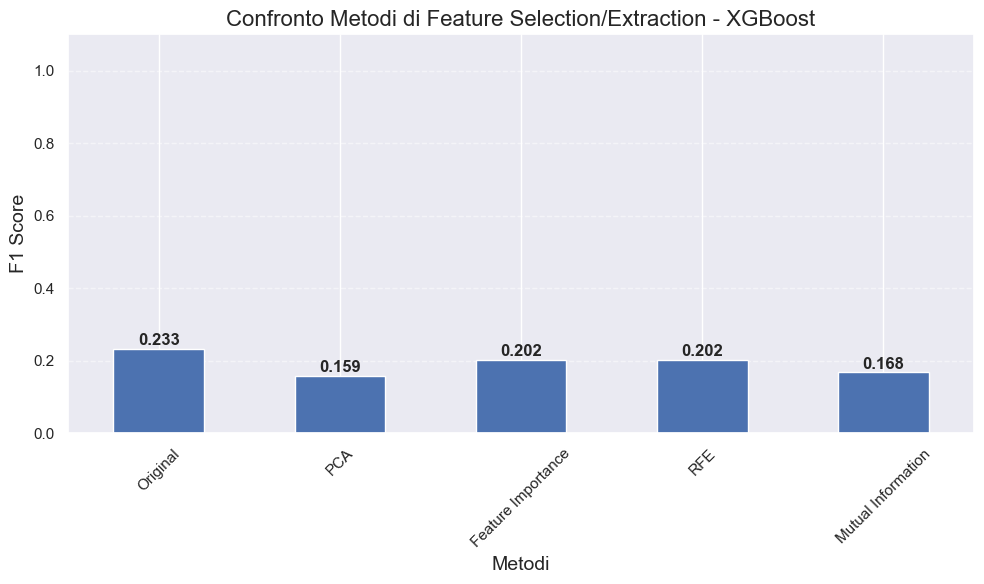

In [35]:
# Visualizza confronto
plt.figure(figsize=(10, 6))
df_compare.T.plot(kind='bar', figsize=(10,6), legend=False)
plt.title(f"Confronto Metodi di Feature Selection/Extraction - {best_model_name}", fontsize=16)
plt.ylabel("F1 Score", fontsize=14)
plt.xlabel("Metodi", fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Aggiungi valori sopra le barre
ax = plt.gca()
for i, v in enumerate(df_compare.values[0]):
    ax.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()